# Augment Segmentation Maps

Segmentation maps are 2D arrays in which every spatial position is assigned to exactly one class. They are represented in `imgaug` using `imgaug.SegmentationMapOnImage`. The class is instantiated as `imgaug.SegmentationMapOnImage(arr, shape, [nb_classes])`. `arr` contains the 2D segmentation map, `shape` is the shape of the corresponding image and `nb_classes` is the number of unique classes that can appear in the map. `nb_classes` is expected to be removed in the future, but currently still has to be provided if `arr` has an int/uint dtype (the most common scenario).

Currently, `imgaug.SegmentationMapOnImage` represents segmentation maps internally as `(H,W,C)` arrays, where `C` is the number of channels. Each component is a float between `0.0` and `1.0`. The class vector associated with each spatial location can be viewed as a one-hot-vector, though its components can sum to more than `1`. When converting this representation to an `(H,W)` integer array, only the id of the class with largest value is kept per location (i.e. `argmax`). However, if that value is below a small threshold (default: `0.01`), a background class will instead be used.

Noteworthy attributes of `imgaug.SegmentationMapOnImage` are `.shape` (shape of the corresponding image) and `.arr` (internal segmentation map representation).

Noteworthy methods of `imgaug.SegmentationMapOnImage` are:
  * `get_arr_int([background_threshold], [background_class_id])`: Converts the internal representation of the segmentation map to an integer dtype and returns it.
  * `draw([size], [background_threshold], [background_class_id], [colors], [return_foreground_mask])`: Converts the segmentation map to an RGB image.
  * `draw_on_image(image, [alpha], [resize], [size], [background_threshold], [background_class_id], [colors], [draw_background])`: Converts the segmentation map to an RGB image and blends it with a provided image.
  * `pad([top], [right], [bottom], [left], [mode], [cval])`: Pad the segmentation map on its sides. Note that this currently pads the *internal segmentation map*, i.e. `cval` should *not* be a class id.
  * `pad_to_aspect_ratio(aspect_ration, [mode], [cval], [return_pad_amounts])`: Pad the segmentation map to an aspect ratio (`width/height`). Note that this currently pads the *internal segmentation map*, i.e. `cval` should *not* be a class id.
  * `resize(sizes, [interpolation])`: Resize the segmentation map to a provided size. As the internal representation is a float, the interpolation can differ from nearest neighbour.

To augment segmentation maps, use `augment_segmentation_maps()`, which is offered by all augmenters. It expects a `SegmentationMapOnImage` or `list of SegmentationMapOnImage`.

For more details, see the [API](https://imgaug.readthedocs.io/en/latest/source/api.html): [imgaug.SegmentationMapOnImage](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.imgaug.SegmentationMapOnImage), [imgaug.augmenters.meta.Augmenter.augment_segmentation_maps()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment_segmentation_maps).

For drawing routines `imgaug.SegmentationMapOnImage` uses a predefined set of colors. These are currently saved in the constant `imgaug.SegmentationMapOnImage.DEFAULT_SEGMENT_COLORS`. They will likely be replaced in the future by a matplotlib colormap, so change only with caution.

**Important**: `imgaug`'s segmentation map augmentation is geared towards ground truth outputs. As such, only augmentation techniques that change the image geometry will be applied to segmentation maps, even when other augmentation techniques are part of a pipeline. Examples for that are e.g. horizontal flips or affine transformations. To also apply non-geometric augmentation techniques, feed the segmentation map array through `augmenter.augment_images()` instead.

## Creating an Example Segmentation Map from Polygons Given as Points

The goal of our first example is to load an image, create a segmentation map and augment both of them. Let's first load and visualize our example image:

(319, 479, 3)


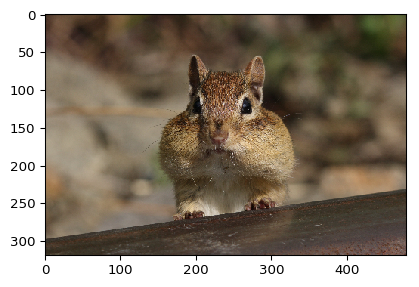

In [1]:
import imageio
import imgaug as ia
%matplotlib inline

image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/f/f4/Tamias_striatus_CT.jpg")
image = ia.imresize_single_image(image, 0.15)
print(image.shape)
ia.imshow(image)

Now we need a segmentation map for that image. We will create two classes, one for the tree (bottom) and one for the chipmunk (center). Everything else will be background. Both classes will be created as polygons and then drawn on a segmentation map array. Let's now define the four corner points of the tree polygon:

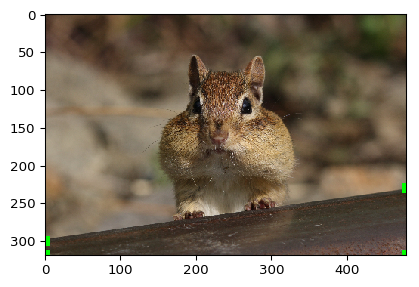

In [2]:
import numpy as np

tree_kps_xy = np.float32([
    [0, 300],  # left top of the tree
    [image.shape[1]-1, 230],  # right top
    [image.shape[1]-1, image.shape[0]-1],  # right bottom
    [0, image.shape[0]-1]  # left bottom
])

# visualize
kpsoi_tree = ia.KeypointsOnImage.from_coords_array(tree_kps_xy, shape=image.shape)
ia.imshow(kpsoi_tree.draw_on_image(image, size=13))

Now we have to create the chipmunk polygon. That one requires significantly more corner points, but the underlying method is the same:

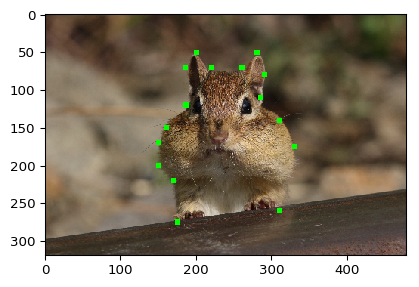

In [3]:
chipmunk_kps_xy = np.float32([
    [200, 50],  # left ear, top (from camera perspective)
    [220, 70],
    [260, 70],
    [280, 50],  # right ear, top
    [290, 80],
    [285, 110],
    [310, 140],
    [330, 175], # right of cheek
    [310, 260], # right of right paw
    [175, 275], # left of left paw
    [170, 220],
    [150, 200],
    [150, 170], # left of cheek
    [160, 150],
    [186, 120], # left of eye
    [185, 70]
])

# visualize
kpsoi_chipmunk = ia.KeypointsOnImage.from_coords_array(chipmunk_kps_xy, shape=image.shape)
ia.imshow(kpsoi_chipmunk.draw_on_image(image, size=7))

In the next step, we convert both sets of corner points to instances of `imgaug.Polygon`. Even though `imgaug` has (at the time of writing this notebook) no support yet for polygon *augmentation*, it can nevertheless already *represent* them as `imgaug.Polygon` instances. We make use of this, because `imgaug.Polygon` has a drawing routine, which will help us to convert the polygons to a single segmentation map. Let's create the two polygons, which is done by simply providing the corner keypoints to `imgaug.Polygon.__init__()`:

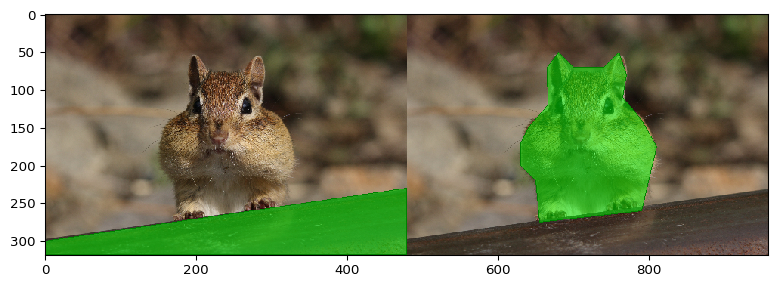

In [4]:
#create polygons
poly_tree = ia.Polygon(kpsoi_tree.keypoints)
poly_chipmunk = ia.Polygon(kpsoi_chipmunk.keypoints)

# visualize polygons
ia.imshow(np.hstack([
    poly_tree.draw_on_image(image),
    poly_chipmunk.draw_on_image(image)
]))

Now we have to convert the two polygons to a single segmentation map. We do this by first creating an empty `(H,W,3)` array for our three classes (background, tree, chipmunk). Then we draw tree and chipmunk polygons onto that array as if it was an image. We use 100% green and 100% blue colors, thereby drawing the tree only into the second image channel and the chipmunk only into the third channel. Then we merge the three channels to a single segmentation map.

In [5]:
# create empty segmentation map for classes background, tree, chipmunk
segmap = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# draw the tree polygon into the second channel
segmap = poly_tree.draw_on_image(
    segmap,
    color=(0, 255, 0), color_perimeter=(0, 255, 0),
    alpha=1.0, alpha_perimeter=0.0)

# draw the chipmunk into the third channel
segmap = poly_chipmunk.draw_on_image(
    segmap,
    color=(0, 0, 255), color_perimeter=(0, 0, 255),
    alpha=1.0, alpha_perimeter=0.0)

# merge the three channels to a single one
segmap = np.argmax(segmap, axis=2)

# draw statistics about our segmentation map
print("Shape:", segmap.shape, "min value:", segmap.min(), "max value:", segmap.max())

Shape: (319, 479) min value: 0 max value: 2


Now we just have to call `imgaug.SegmentationMapOnImage` with that segmentation map and can draw the result on an image.

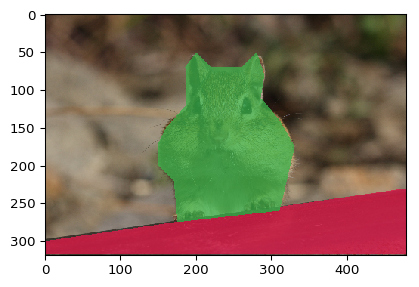

In [6]:
segmap = ia.SegmentationMapOnImage(segmap, nb_classes=3, shape=image.shape)
ia.imshow(segmap.draw_on_image(image))

## Augment the Example Segmentation Map

After creating an example segmentation map, we now want to augment it (and the corresponding image). First, we create the augmentation sequence, consisting of a bit of coarse dropout (sets rectangular areas to zero), an affine transformation and an elastic trnasformation (water-like effect). Note that only `Affine` and `ElasticTransformation` will actually affect the segmentation map, as segmentation map augmentation only applies augmenters that change the geometry to segmentation maps.

In [7]:
import imgaug.augmenters as iaa
ia.seed(2)

aug = iaa.Sequential([
    iaa.CoarseDropout(0.1, size_percent=0.2),
    iaa.Affine(rotate=(-30, 30)),
    iaa.ElasticTransformation(alpha=10, sigma=1)
])

Now we apply the augmentation to the segmentation map and image. To do that, we first have to switch the augmentation sequence to deterministic mode. This ensures that image and segmentation map are augmented in the same way. Note that if you had multiple batches to augment, you would have to call `to_deterministic()` once before every batch, otherwise you would augment all of them using the same random samples.

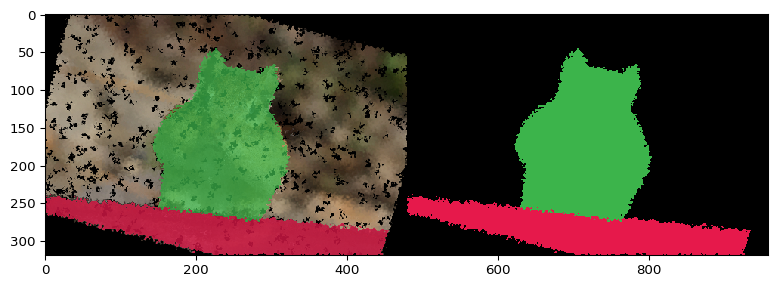

In [8]:
# switch to deterministic mode
aug_det = aug.to_deterministic()

# augment
image_aug = aug_det.augment_image(image)
segmap_aug = aug_det.augment_segmentation_maps(segmap)

# visualize
ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug),  # show blend of (augmented) image and segmentation map
    segmap_aug.draw()  # show only the augmented segmentation map
]))

Note how the segmentation map is affected by the affine transformation (i.e. rotated) and the elastic transformation (i.e. water-like effect, here fairly noisy). It is not affected by coarse dropout as that augmenter does not change the image geometry. (Note also that coarse dropout here did drop rectangular areas, which appear now non-rectangular as the elastic transformation was applied afterwards and roughened up the rectangles.)

The elastic transformation above is quite noisy, making it hard to see whether image and segmentation map augmentation are aligned. Let's execute it on its own with less noisy settings. Let's also execute it once *without* `to_deterministic()`, i.e. *without* alignment:

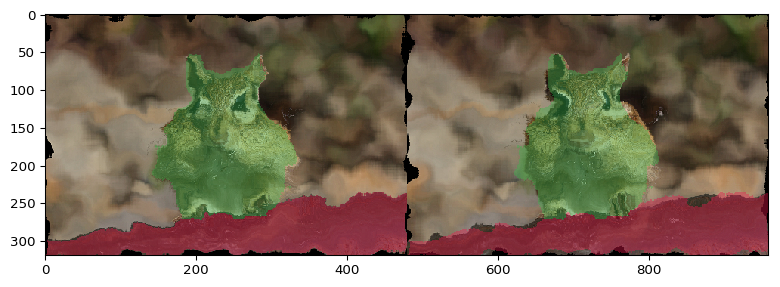

In [9]:
aug = iaa.ElasticTransformation(alpha=200, sigma=10)

# with to_deterministic() (correct)
aug_det = aug.to_deterministic()
image_aug = aug_det.augment_image(image)
segmap_aug = aug_det.augment_segmentation_maps(segmap)

# without to_deterministic() (incorrect)
image_aug_unaligned = aug.augment_image(image)
segmap_aug_unaligned = aug.augment_segmentation_maps(segmap)

ia.imshow(
    np.hstack([
        segmap_aug.draw_on_image(image_aug, alpha=0.4),
        segmap_aug.draw_on_image(image_aug_unaligned, alpha=0.4)
    ])
)

## Augment using augmenters.augment_batches()

The above examples used an explicit call to `to_deterministic()` to ensure alignment between image and segmentation map augmentation. This can be avoided by calling instead `augment_batches()`, which expects a list of `imgaug.Batch` instances. These are easy to create in the form of `imgaug.Batch(images=<list of numpy arrays>, segmentation_maps=<list of imgaug.SegmentationMapOnImage>)`. The following example applies an elastic transformation using `augment_batches()`:

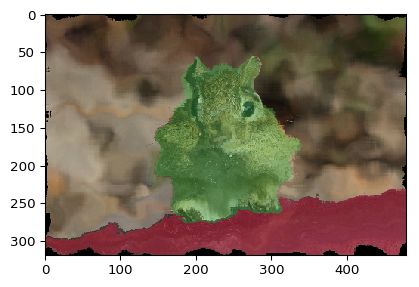

In [10]:
aug = iaa.ElasticTransformation(alpha=200, sigma=10)

# merge image and segmentation map to imgaug.Batch instance
batch = ia.Batch(images=[image], segmentation_maps=[segmap])

# augment, note that augment_batches() returns a generator
batch_aug = list(aug.augment_batches([batch]))[0]

# convert augmented batch to augmented image + segmentation map
image_aug = batch_aug.images_aug[0]
segmap_aug = batch_aug.segmentation_maps_aug[0]

# visualize
ia.imshow(segmap_aug.draw_on_image(image_aug, alpha=0.4))

Using `augment_batches()` has the advantage that it allows to easily activate multicore augmentation, by calling it via `augment_batches(..., background=True)`.

## Scaling Segmentation Maps

Segmentation maps often have to be resized, e.g. to create lower-resolution ground truth outputs for a network. This can be done using the `resize()` method. The following example uses the method to resize a segmentation map to 1/4th of its original. Alternatively, a fixed size like `(100, 200)` could also be used to get an output map with height 100 and width 200.

In [11]:
segmap_small = segmap.resize(0.25)
print("Before:", segmap.arr.shape, "After:", segmap_small.arr.shape)

Before: (319, 479, 3) After: (80, 120, 3)


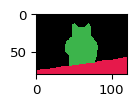

In [12]:
ia.imshow(segmap_small.draw())

Let's visualize the segmentation map before and after resizing, projected onto the image (i.e. again resized, back to the image size). The map after resizing (right) is visibly more coarse.

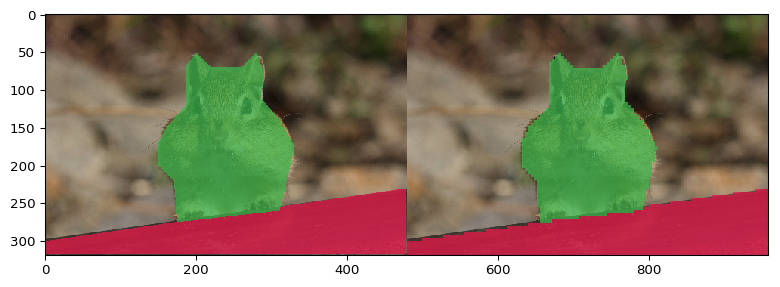

In [13]:
ia.imshow(
    np.hstack([
        segmap.draw_on_image(image),
        segmap_small.draw_on_image(image)
    ])
)

## Augment Segmentation Maps Smaller than their Corresponding Image

It is quite common that the ground truth output segmentation map of a network is smaller than the input image. This scenario is handled automatically by `imgaug`. Simply feed the smaller-sized segmentation map through the augmentation pipeline as if it was of the same size as the image. Just make sure that the `.shape` attribute of `SegmentationMapOnImage` matches the image size (as it always should).

The following example augments the example image and the previously downscaled segmentation map. Let's first print the array shapes:

In [14]:
print("Image size: %s Segmentation Map size: %s (on image shape: %s)" % (
    image.shape, segmap_small.arr.shape, segmap_small.shape))

Image size: (319, 479, 3) Segmentation Map size: (80, 120, 3) (on image shape: (319, 479, 3))


And now we augment and visualize the image and the smaller scale segmentation map.

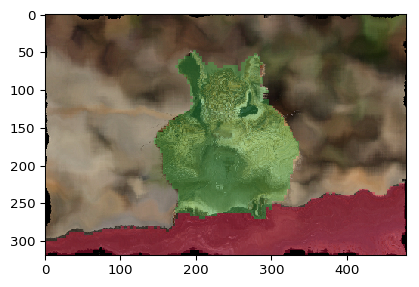

In [15]:
aug = iaa.ElasticTransformation(alpha=200, sigma=10)

aug_det = aug.to_deterministic()
image_aug = aug_det.augment_image(image)
segmap_small_aug = aug_det.augment_segmentation_maps(segmap_small)

ia.imshow(segmap_small_aug.draw_on_image(image_aug, alpha=0.4))

Augmentation of smaller sized segmentation maps still works, even if parameters denote pixel values. The following example shows a common scenarion where the image is cropped by a set amount of pixels (50 at the bottom, 200 on the left side). The pixel amounts are transformed to corresponding pixel amounts for the smaller sized segmentation map. (For comparison, we also augment the image-sized segmentation map.)

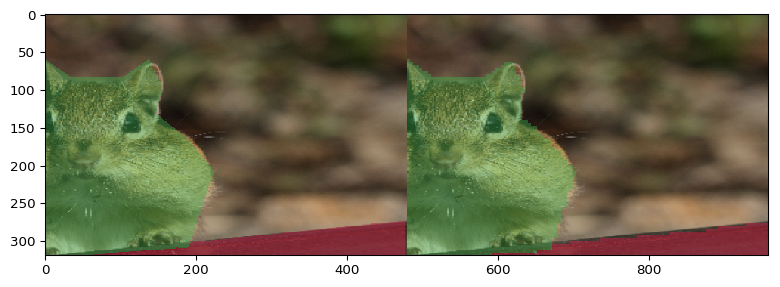

In [16]:
aug = iaa.Crop(px=(0, 0, 50, 200))  # (top, right, bottom, left)

aug_det = aug.to_deterministic()
image_aug = aug_det.augment_image(image)  # augment image
segmap_aug = aug_det.augment_segmentation_maps(segmap)  # augment normal-sized segmentation map
segmap_small_aug = aug_det.augment_segmentation_maps(segmap_small)  # augment smaller-sized segmentation map

ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug, alpha=0.4),  # draw augmented normal-sized segmentation map
    segmap_small_aug.draw_on_image(image_aug, alpha=0.4)  # draw augmented smaller-sized segmentation map
]))

Even though both augmented segmentation maps (normal scale of the left, smaller scale on the right) here are automatically upscaled to the image size and hence both seem to have the same resolution, the smaller segmentation map leads to visibly rougher edges.

## Convert Augmented Segmentation Maps to Numpy Arrays

The internal array in `SegmentationMapOnImage`, accessible via the `.arr` attribute, has a float32 dtype and one channel per class. Usually, this is not what one would want as a segmentation map numpy array. To instead get a single-channel integer array, the method `SegmentationMapOnImage.get_arr_int()` has to be called. The example below accesses both, `.arr` and `.get_arr_int()`, and shows their dtype, minimum and maximum value.

In [17]:
arr = segmap.arr
arr_int = segmap.get_arr_int()

print("[segmap.arr]           Shape:", arr.shape,
      "dtype:", arr.dtype,
      "min:", arr.min(),
      "max:", arr.max())
print("[segmap.get_arr_int()] Shape:", arr_int.shape,
      "dtype:", arr_int.dtype,
      "min:", arr_int.min(),
      "max:", arr_int.max())

[segmap.arr]           Shape: (319, 479, 3) dtype: float32 min: 0.0 max: 1.0
[segmap.get_arr_int()] Shape: (319, 479) dtype: int32 min: 0 max: 2


## Pad Segmentation Maps

Similarly to images, segmentation maps can be padded using `SegmentationMapOnImage.pad()`. The padding is currently performed on the internal array representation. Hence, the `cval` parameter should not be set to a class id and it is often best to such a mode such as `edge` or `constant` with `cval=0.0`. The following example showcases both of these modes. It first pads image and segmenation map both with `0.0` and afterwards pads them both using `edge` mode.

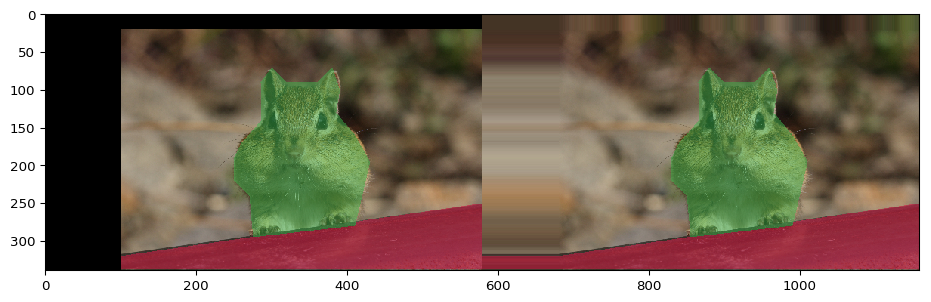

In [18]:
image_pad_constant = ia.pad(image, left=100, top=20)
segmap_pad_constant = segmap.pad(left=100, top=20)

image_pad_edge = ia.pad(image, left=100, top=20, mode="edge")
segmap_pad_edge = segmap.pad(left=100, top=20, mode="edge")

ia.imshow(np.hstack([
    segmap_pad_constant.draw_on_image(image_pad_constant, alpha=0.5),
    segmap_pad_edge.draw_on_image(image_pad_edge, alpha=0.5),
]))

When using edge mode, one has to be careful with classes that do not fully extend to the image edges. The below example pads image and segmentation again using `edge` mode, but now pads on the left and right side. While the padding of the segmentation map behaves as expected on the left side, it does not extend the class on the right side.

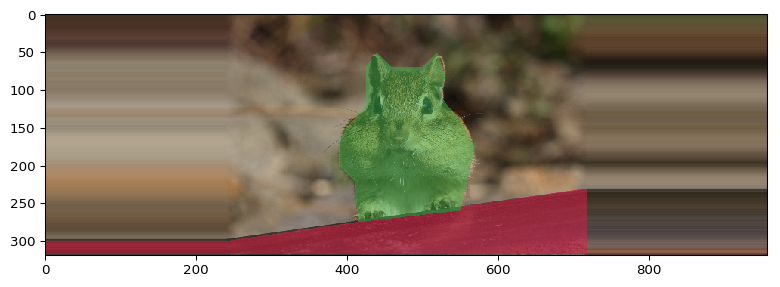

In [19]:
image_wide = ia.pad_to_aspect_ratio(image, 3.0, mode="edge")
segmap_wide = segmap.pad_to_aspect_ratio(3.0, mode="edge")

ia.imshow(segmap_wide.draw_on_image(image_wide, alpha=0.5))

The reason for the above problem is that the drawing routine, which was used to add the tree polygon to the segmentation map, stopped just slightly short of the right side. The output below demonstrates this. It shows the maximum values for each of the three classes (background, tree, chipmunk) for the last five columns of the segmentation map. The tree class extends only up to the second to last column.

In [20]:
print(np.max(segmap.arr[:, -5:, :], axis=0))

[[1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]]


## Draw Segmentation Maps

The above examples already made use of the drawing methods offered by `SegmentationMapOnImage`. One of these methods is `draw()`, which converts the segmentation map to an RGB image. The example below uses that method to visualize a segmentation map before and after augmentation:

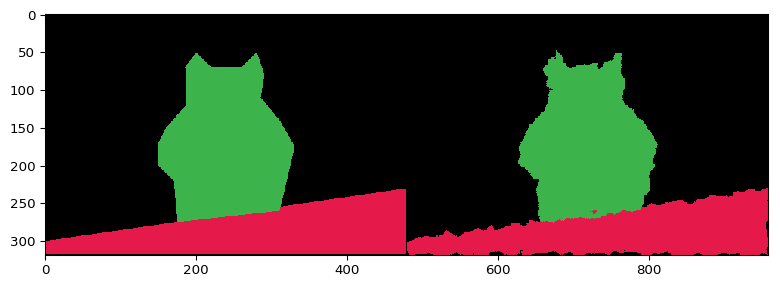

In [21]:
segmap_aug = iaa.ElasticTransformation(alpha=50, sigma=5).augment_segmentation_maps(segmap)
ia.imshow(np.hstack([
    segmap.draw(),
    segmap_aug.draw(),
]))

The `draw()` method offers an optional parameter `return_foreground_mask`. If set to true, an additional boolean array is returned that marks all spatial locations which do not belong to the background class. This boolean array is used below to convert all non-background pixels to a uniform color:

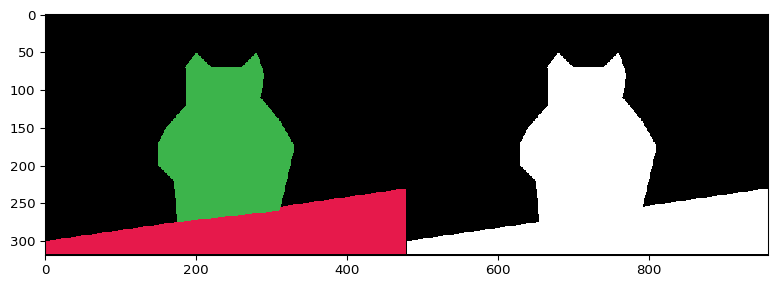

In [22]:
image_seg, foreground_mask = segmap.draw(return_foreground_mask=True)
image_seg_masked = np.copy(image_seg)
image_seg_masked[foreground_mask] = [255, 255, 255]
ia.imshow(np.hstack([
    image_seg,
    image_seg_masked
]))

Additionally, the parameter `background_class_id` can changed, to control which class id is interpreted as the background in `draw`:

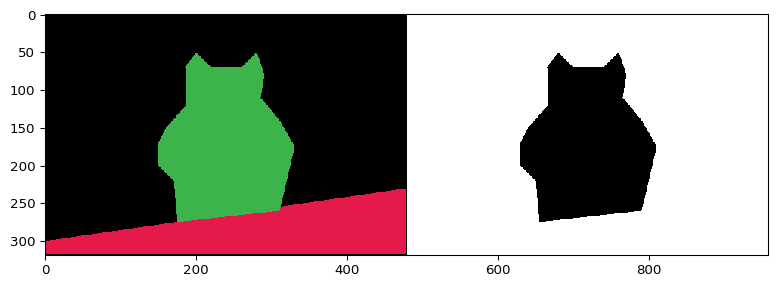

In [23]:
image_seg, foreground_mask = segmap.draw(background_class_id=2, return_foreground_mask=True)
image_seg_masked = np.copy(image_seg)
image_seg_masked[foreground_mask] = [255, 255, 255]
image_seg_masked[~foreground_mask] = [0, 0, 0]
ia.imshow(np.hstack([
    image_seg,
    image_seg_masked
]))

In case other colors than the default ones are desired, the parameter `colors` can be used to define them. It has to be set to a list with one iterable per class. Each iterable must contain three uint8 values.

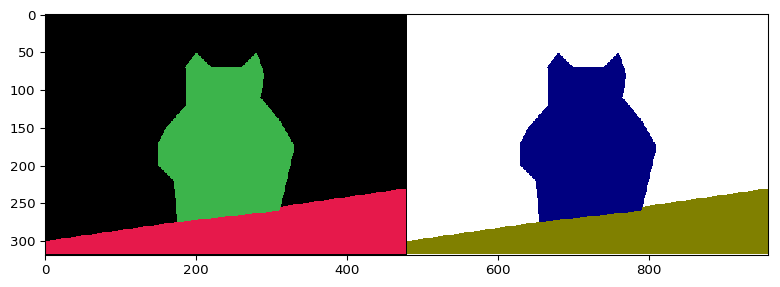

In [24]:
ia.imshow(np.hstack([
    segmap.draw(),
    segmap.draw(colors=[(255, 255, 255), (128, 128, 0), (0, 0, 128)]),
]))

For easy scaling, `draw` also offers a `size` parameter, which can be set to e.g. a `(height, width)` tuple or a fraction, as in the following example:

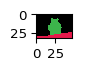

In [25]:
ia.imshow(segmap.draw(0.1))

The previously used method `draw_on_image()` first converts the segmentation map to an RGB image (like `draw()` does), then resizes it to the image (or the other way round, depending on arguments), and then blends image and RGB-representation of the segmentation map.

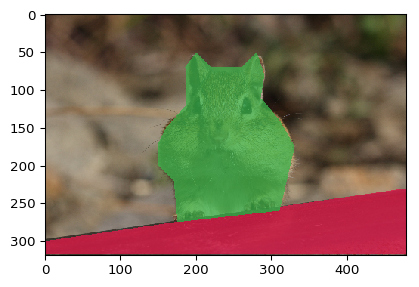

In [26]:
ia.imshow(segmap.draw_on_image(image))

During the blending of the image and the segmentation map's RGB-representation, the opacity of the segmentation map can be controlled using the `alpha` argument:

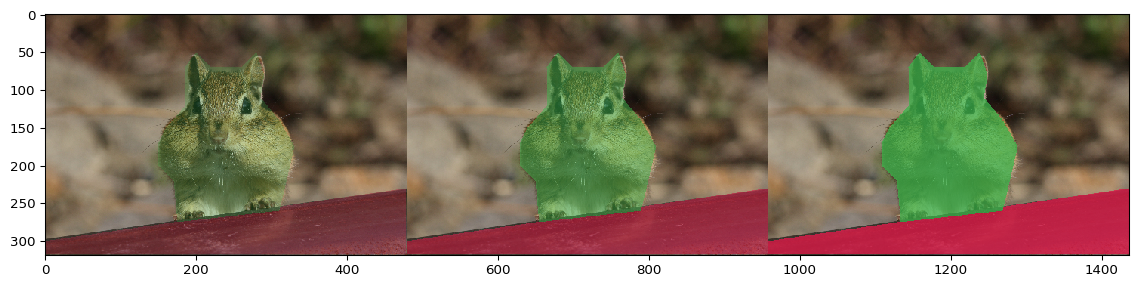

In [27]:
ia.imshow(np.hstack([
    segmap.draw_on_image(image, alpha=0.25),
    segmap.draw_on_image(image, alpha=0.50),
    segmap.draw_on_image(image, alpha=0.75)
]))

Usually, pixels having the background class are ignored in the blending. This can be changed using `draw_background=True`. The default color for the background is black.

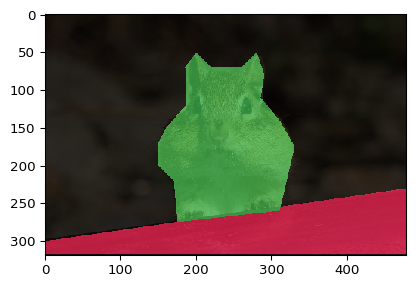

In [28]:
ia.imshow(segmap.draw_on_image(image, draw_background=True))

Alternatively, using `background_class_id` it is possible to control which class is supposed to be treated as background and hence ignored in the blending.

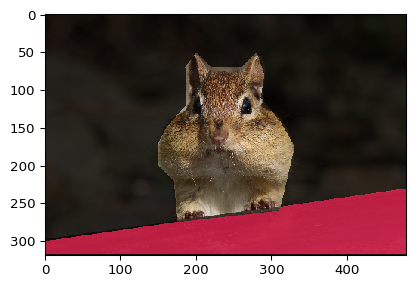

In [29]:
ia.imshow(segmap.draw_on_image(image, draw_background=False, background_class_id=2))

`draw_on_image()` can handle different sizes between image and segmentation map. By default, the segmentation map is resized to the image size using nearest neighbour upsampling. The following example uses a segmentation map with 20% of the image size to show this:

(64, 96, 3) (319, 479, 3)


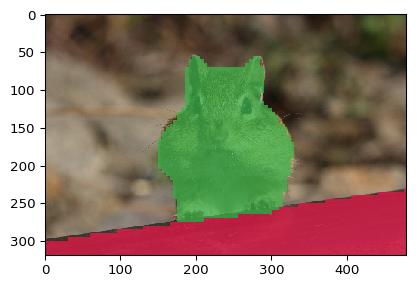

In [30]:
segmap_small = segmap.resize(0.2)
print(segmap_small.arr.shape, image.shape)

ia.imshow(segmap_small.draw_on_image(image))

Instead of resizing the segmentation map to the image, the image can instead be resized to the segmentation map's size using the `resize` argument:

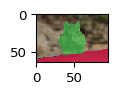

In [31]:
ia.imshow(segmap_small.draw_on_image(image, resize="image"))

## Change Segmentation Maps by Non-Geometric Augmentations

By default, the segmentation map augmentation using `augment_segmentation_maps()` is geared towards ground truth augmentation and hence only applies geometric forms of augmentation. If that limitation is undesired, the segmentation maps have to be treated as raw arrays and fed through `augment_images()`. The following code block first introduces an example using ordinary `augment_segmentation_maps()`, which is then changed to `augment_images()` in the code block right afterwards:

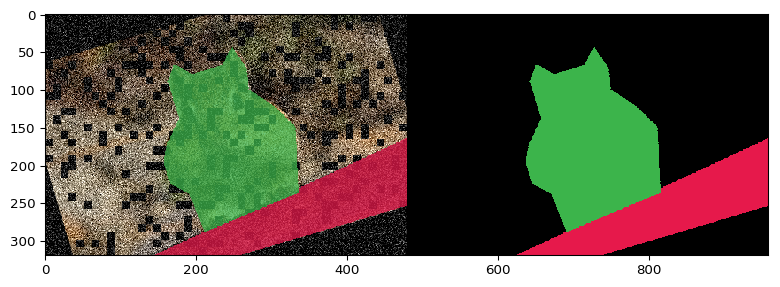

In [32]:
# example augmentation pipeline
aug = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20)),  # only this affects segmentation maps via augment_segmentation_maps()
    iaa.CoarseDropout(0.2, size_percent=0.1),
    iaa.AdditiveGaussianNoise(scale=0.2*255)
])

# standard way of augmenting segmentation maps via augment_segmentation_maps()
aug_det = aug.to_deterministic()
image_aug = aug_det.augment_image(image)
segmap_aug = aug_det.augment_segmentation_maps(segmap)

# visualize before/after
ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug),
    segmap_aug.draw()
]))

And know we augment the segmentation maps with `Affine` and the non-geometric `CoarseDropout`. However, we do not want to apply `AdditiveGaussianNoise` to the segmentation maps, only to the images. A fairly simple way to achieve this is to use two different augmentation pipelines, one for images and one for segmentation maps. We then initialize each augmenter with a hand-adjusted seed via `random_state=<seed>`. By choosing matching seeds between the two pipelines, we can ensure that the augmenters draw the same samples.

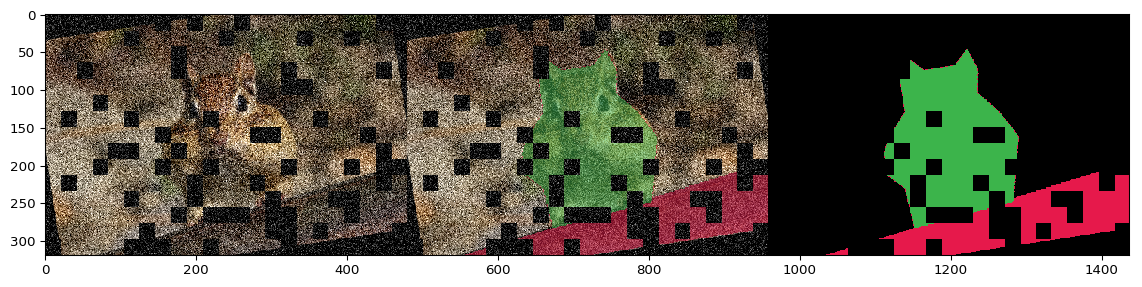

In [33]:
# augmentation pipeline for images
aug_images = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20), random_state=1),
    iaa.CoarseDropout(0.2, size_percent=0.05, random_state=2),
    iaa.AdditiveGaussianNoise(scale=0.2*255, random_state=3)
], random_state=4)

# augmentation pipeline for segmentation maps - with coarse dropout, but without gaussian noise
aug_segmaps = iaa.Sequential([
    iaa.Affine(rotate=(-20, 20), random_state=1),
    iaa.CoarseDropout(0.2, size_percent=0.05, random_state=2)
], random_state=4)

# augment
# We don't need to_deterministic() here as the random states are already identical
# and therefore will lead to aligned augmentations.

# First, augment image.
image_aug = aug_images.augment_image(image)

# Second, augment segmentation map.
# We convert to uint8 as that dtype has usually best support and hence is safest to use.
segmap_arr_aug = aug_segmaps.augment_image(segmap.get_arr_int().astype(np.uint8))
segmap_aug = ia.SegmentationMapOnImage(segmap_arr_aug, nb_classes=3, shape=segmap.shape)

# visualize
ia.imshow(np.hstack([
    image_aug,
    segmap_aug.draw_on_image(image_aug, alpha=0.5),
    segmap_aug.draw()
]))

Note that when augmenting segmentation maps via `augment_images()`, size differences are not automatically accounted for. So while augmentations via `augment_segmentation_maps()` can be done with segmentation maps that are smaller than the corresponding images, the sizes should match if using `augment_images()`. Otherwise, the two pipelines have to be manually adjusted to match despite different sizes. E.g. `Crop` should then be used with fractions instead of raw pixel values as arguments -- or alternatively the pixel values have to be different between the pipelines.